In [26]:
from wfield import *

SVT = np.load('SVT.npy')
SVT_470 = SVT[:,::2]
SVT_405 = SVT[:,1::2]
U = np.load('U.npy')
T = np.load('T.npy')

In [27]:
del SVT

In [28]:
%matplotlib notebook
freq_highpass = 0.1
fs = 15
SVTa = SVT_470
t = np.arange(SVTa.shape[1]*2) # interpolate the violet
from scipy.interpolate import interp1d
SVT_405 = interp1d(t[1::2],SVT_405,axis=1,
                   fill_value='extrapolate')(t[0::2])
SVTb = SVT_405

SVTa = highpass(SVTa,w = freq_highpass, fs = fs).astype(np.float32)
SVTb = highpass(SVTb,w = freq_highpass, fs = fs).astype(np.float32)
nchunks = 1500
if len(U.shape) == 3:
    dims = U.shape
    U = U.reshape(-1,dims[-1])
npix = U.shape[0]
idx = np.array_split(np.arange(0,npix),nchunks)
from wfield.hemocorrection import _hemodynamic_find_coeffs
rcoeffs = runpar(_hemodynamic_find_coeffs,
                 [U[ind,:] for ind in idx],
                 SVTa=SVTa,
                 SVTb=SVTb)
rcoeffs = np.hstack(rcoeffs).astype('float32')
rcoeffs[np.isnan(rcoeffs)] = 1.e-10
# find the transformation
T = np.dot(np.linalg.pinv(U),(U.T*rcoeffs).T)
# apply correction
SVTcorr = SVTa - np.dot(T.T,SVTb)
# return a zero mean SVT
SVTcorr = (SVTcorr.T - np.nanmean(SVTcorr,axis=1)).T.astype('float32')
rcoeffs = rcoeffs.astype('float32').reshape(dims[:2])
SVTb_s = np.dot(T.T,SVTb)


In [ ]:
plt.figure()

nb_play_movie(s2,clim = [-.05,0.05],cmap='RdBu_r')

In [154]:
# Prepare for plotting
lmarks = load_allen_landmarks('./dorsal_cortex_landmarks.json')
ccf_regions,proj,brain_outline = allen_load_reference('dorsal_cortex')
bout = brain_outline/lmarks['resolution'] + np.array(lmarks['bregma_offset'])
mask = contour_to_mask(*bout.T,dims = s[0].shape)

U = np.load('U.npy')
if 'dims' in dir():
    U = U.reshape(dims)

# warp and mask U, first make boarders zero
from wfield.imutils import mask_to_3d
U[:,0,:] = 0
U[0,:,:] = 0
U[-1,:,:] = 0
U[:,-1,:] = 0
U = np.stack(runpar(im_apply_transform,
                    U.transpose([2,0,1]),
                    M = lmarks['transform']))
U[mask_to_3d(mask,U.shape)==0] = np.nan
U = U.transpose([1,2,0])

s = SVDStack(U,np.dot(T,SVTb)) # violet channel==0
s1 = SVDStack(U,SVTa) # blue channel
s2 = SVDStack(U,SVTa - np.dot(T,SVTb)) # corrected

(array([193.1189818]), array([245.34222618]))

<IPython.core.display.Javascript object>


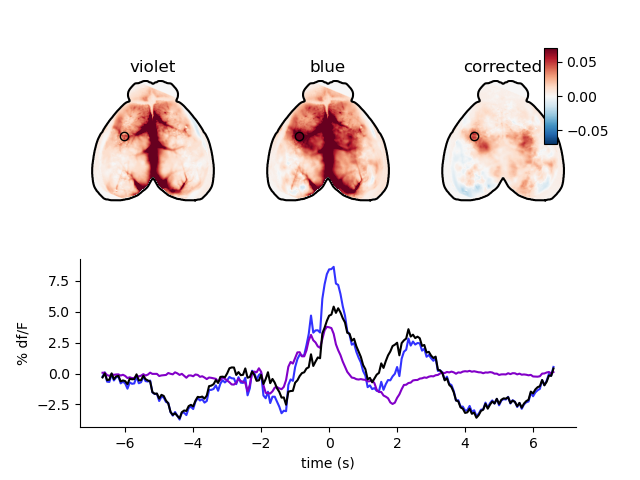

In [187]:
# the actual plot
frame = 888
fig = plt.figure()
ax = []
for e,i in enumerate([s[frame],s1[frame],s2[frame]]):
    ax.append(fig.add_subplot(2,3,e+1))
    plt.plot(bout[:,0],bout[:,1],'k')
    plt.imshow(i,
               cmap = 'RdBu_r',clim = [-0.07,0.07])
    plt.axis('off')
ax[0].set_title('violet')
ax[1].set_title('blue')
ax[2].set_title('corrected')
xy = [193,245]
for a in ax:
    a.plot(*xy,'ko',markerfacecolor='none')

x  = np.arange(-100,100)/15.
fig.add_subplot(2,1,2)
# plt.colorbar(shrink = 0.3)
tmp = np.zeros_like(s[frame])
tmp[xy[1]-10:xy[1]+10,xy[0]-10:xy[0]+10] = 1
idx = np.ravel_multi_index(np.where(tmp == 1),s1.shape[1:])
t = np.nanmean(s1.Uflat[idx,:].dot(s1.SVT[:,-100+frame:100+frame]),axis = 0)
plt.plot(x,t*100,color=np.array([50,50,255])/255)
t = np.nanmean(s.Uflat[idx,:].dot(s.SVT[:,-100+frame:100+frame]),axis = 0)
plt.plot(x,t*100,color=np.array([130,0,200])/255)
t = np.nanmean(s2.Uflat[idx,:].dot(s2.SVT[:,-100+frame:100+frame]),axis = 0)
plt.plot(x,t*100,'k')

plt.ylabel('% df/F')
plt.xlabel('time (s)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
cax = fig.add_axes([.85,.7,.02,.2])
plt.colorbar(cax = cax)
plt.savefig('hemodynamic_correction_fig.pdf')

<IPython.core.display.Javascript object>


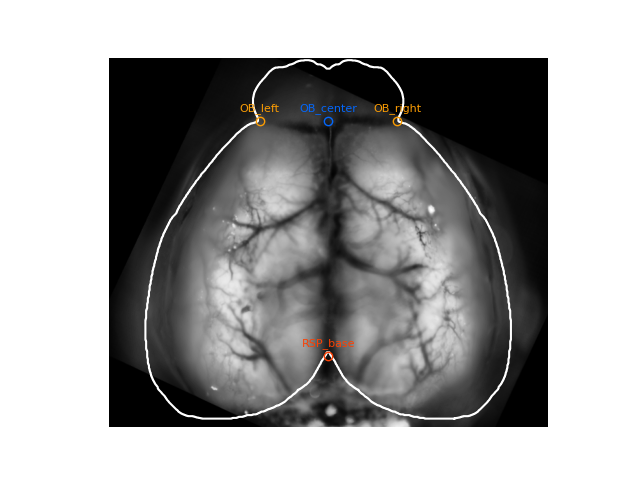

#fc9d03
#0367fc
#fc9d03
#fc4103


In [251]:
plt.matplotlib.rcParams['pdf.fonttype'] = 42
plt.matplotlib.rcParams['ps.fonttype'] = 42

lmarks = load_allen_landmarks('./dorsal_cortex_landmarks.json')
avg  = np.load('./frames_average.npy')
im = im_apply_transform(avg[0],lmarks['transform'])
plt.figure()
plt.imshow(im_adapt_hist(im.astype('uint16'),10),clim = [0,65000],
           alpha = 1,cmap='gray')
plt.plot(bout[:,0],bout[:,1],'w')
for i,x in enumerate((np.vstack([lmarks['landmarks'].x,
                                 lmarks['landmarks'].y]).T/
                      lmarks['resolution'] + lmarks['bregma_offset'])):
    color = lmarks['landmarks'].color.iloc[i]
    print(color)
    plt.plot(x[0],x[1],'o',markeredgecolor=color,
             markerfacecolor = 'none')
    plt.text(x[0],x[1]-10,lmarks['landmarks'].name.iloc[i],color=color,
             va='bottom',ha='center',fontsize=8)

plt.axis('off')
plt.savefig('ref_landmarks.pdf')